<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Advanced Algorithm 4: Deep Factorization Machine Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)

&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#data-setup) 

[Deep Factorization Machine Classifier](#all-feats)  
&nbsp;&nbsp;&nbsp;[Set Parameters](#undersampling)  
&nbsp;&nbsp;&nbsp;[Run Model](#oversampling)

[Compare to Other Advanced Models](#compare)

[Predict on Other Years of Indonesia Survey Data](#robust)

[Summary](#summary)

# Deep Factorization Machine Classifier Introduction <a class="anchor" id="introduction"></a>

In an earlier notebook, we introduced the basic concepts behind a deep learning approach to feed-forward neural netork classification. In that notebook, "deep learning" essentially means using many hidden layers in a standard multi layer perceptron. We introduced the Keras deep learning library to show how to implement this approach.

Deep learning is a rapidly changing field offering many interesting approaches to machine learning. Yes, deep learning models are based on neural networks, but neural networks themselves are better thought of as building blocks for more sophisticated computations. Basic networks can be combined into modules, and modules can be combined into more computationally sophistocated groups, as we will now demonstrate.

In this notebook, we will apply the recently introduced [deep factorization machine](https://arxiv.org/pdf/1703.04247.pdf) (DeepFM) classifier to the Indonesia dataset. Based on Google's [wide and deep](https://arxiv.org/pdf/1606.07792.pdf) approach to click-through prediction for advertising, the DeepFM model uses a special layer to combine two types of networks into one. The two components are intended to specialize in processing different types of data. One component excels in categorical data, which comprises much of our data sets. The other excels in continuous data, which although less present still exists wthin our data.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

Recently, a model introduced by [researchers at Google](https://arxiv.org/pdf/1606.07792.pdf) proposed combining the strengths of wide and deep networks. The original aim of this work was to utilize the handle high-dimensional sparse data common in click-through rate (CTR) analysis to make recommendations to users in in the Google Play store. The model's *wide* part makes recommendations based on specific co-occurrences chosen by the programmer; this approach does not generalize to correlations that have not appeared in the data. The *deep* part makes recommendations based on the abstract correlations learned by the hidden layers of a neural network. When these modules are coupled together and jointly trained, the model achieves significant improvements compared to each decoupled component predicting alone.
 
The dataset we consider, household level poverty surveys, have a similar structure to the CTR data. Namely both are high dimensional datasets of primarily binary features. While it may appear that the wide and deep approach could be useful for the high-dimensional sparse poverty survey data, there is an important bottleneck to consider: the original network architecture requires manual selection of the features in the wide component. That is, the programmer must decide a priori which interaction terms the model will consider. This problem could be circumvented by considering all possible pairs of feature interactions, but such an approach is often extremely inefficient due to the dimensionality of the feature vectors.

A solution to manually engineering feature interactions was offered by [Guo et al.](https://arxiv.org/pdf/1703.04247.pdf), which proposes a *deep factorization machine* (DeepFM). The DeepFM model, shown below, makes use of a dense embedding layer as a singular input to both the wide and deep modules of the model. The dense embedding transformation maps discrete inputs to a lower-dimensional continuous space. From here, the wide component can efficiently compute higher-order feature pairs by using a [factorization machine](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) (FM) layer as an operation in the wide part of the network. Instead of learning feature interactions explicitly, FM layers represent features by a fixed size latent vector and learn the inner products of latent interactions, effectively acting as another dense encoding. These latent vectors can be pre-computed and reduce feature interaction complexity to linear time. The wide part of the model is then able to assign non-zero weights to interactions in linear time. In the same way that this is approach is useful for the CTR data, it is useful for the poverty data as well, since it is computationally expensive to compute all interactions explicitly.

<img alt="deepfm" src="img/deepfm.png" width=500/>

## Considerations <a class="anchor" id="introduction-considerations"></a>

Deep learning models run best on machines with a GPU. This notebook was developed on such a machine. **If you don't have a GPU**, the code will still execute, but it may be _much_ (more than 10 times) slower.

**NOTE** The DeepFM implementation we use here is based on [Tensorflow](https://www.tensorflow.org/) (the lower-level backbone underlying Keras). The original code is available on [GitHub](https://github.com/ChenglongChen/tensorflow-DeepFM). We have modified the code to be better-suited for our purposes. Due to the complexity of the implementation, however, the code imported below is stored in the `src/models/deepfm/` directory of this project. It is not available in scikit-learn.

# Data setup <a class="anchor" id="data-setup"></a>

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

# model functions
sys.path.append('../src/models/')


from deepfm import config
from deepfm.DeepFM import DeepFM
from deepfm.DataReader import FeatureDictionary, DataParser
from deepfm.metrics import gini_norm, f1

from deepfm.main import run_base_model_dfm
from deepfm.main import load_data_for_deepfm

# country loading
sys.path.append("../../")
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from data.sampler import Sampler

sys.path.append("../")
from evaluation import calculate_metrics, evaluate_model, load_model

ALGORITHM_NAME = 'deepfm'
COUNTRY = 'idn'
STORE_MODEL = True

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


The DeepFM model expects the data to be structured in a slightly different way than the other models we've looked at. We still use the standard loading function and exact data we've used throughout this project, but those operations are performed inside of a special loading function written specifically for DeepFM. That function loads the data as normal, but then assembles some extra information to pass to the DeepFM model. None of the features themselves change, just the datastructure used.

In [2]:
# load data with DeepFM loader
dfTrain, dfTest, X_train, y_train, X_test, ids_test, cat_features_indices = load_data_for_deepfm(COUNTRY)

# index folds for cross-validation
folds = list(StratifiedKFold(n_splits=config.NUM_SPLITS, shuffle=True,
                             random_state=config.RANDOM_SEED).split(X_train, y_train))

# Deep Factorization Machine Classifier <a class="anchor" id="#all-feats"></a>

## Set parameters

Here we will set the parameters for the DeepFM model.
* `use_fm` tells the constructor to use the factorization machine for interactions (the wide component of the model)
* `use_deep` tells the constructor to use the deep component of the model
* `embedding_size` controls the feature embedding
* `dropout_fm` uses dropout in the factorization machine to help avpod overfitting
* `deep_layers` controls the number of layers and dimensionality in the deep part of the network
* `dropout_deep` controls dropout in the deep part of the network
* `deep_layers_activation` determines the activation function used between layers (the nonlinearity)
* `epoch` the number of passes to make through the data when training
* `batch_size` the amount of data to fit for each iteration during an epoch
* `learning_rate` the gradient descent parameter that controls the size of the step during backpropogation (optimization)
* `optimizer_type` the optimization method to use for gradient descent
* `batch_norm` whether to use batch normalization, which controls the size of gradients during optimization
* `batch_norm_decay` controls how batch normalization is decreased as training progresses
* `l2_reg` size og the constant multiplier for the regularization term
* `verbose` controls model output during training
* `eval_metric` metric used to score the model (no relation to training)
* `random_seed` seed for the model


In [3]:
dfm_params = {
    "use_fm": True,
    "use_deep": True,
    "embedding_size": 8,
    "dropout_fm": [1.0, 1.0],
    "deep_layers": [64, 32, 32, 16, 8],
    "dropout_deep": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    "deep_layers_activation": tf.nn.relu,
    "epoch": 50,
    "batch_size": 1024,
    "learning_rate": 0.01,
    "optimizer_type": "adam",
    "batch_norm": 1,
    "batch_norm_decay": 0.895,
    "l2_reg": 0.001,
    "verbose": True,
    "eval_metric": f1,
    "random_seed": config.RANDOM_SEED,
}

## Run model

The model is quite intricate and implemented as a class in the file `src/models/deepfm/DeepFM.py`. The function called below handles the loading and training of the model for the sake of brevity. If the `verbose` parameter is `True`, then training performance will be output to the notebook in real time.

By default this model uses cross-validation. Using the `run_base_model_dfm` function allows us to simply pass the training and testing data, along with information about the folds for cross-validation. The `dfm_params` parameter dictionary defined above sets model parameters.

In [4]:
y_train_dfm, y_test_dfm, dfm = run_base_model_dfm(dfTrain, dfTest, folds, dfm_params)

#params: 244325
[1] train-result=0.1263, valid-result=0.1148 [10.1 s]
[2] train-result=0.4494, valid-result=0.4398 [9.9 s]
[3] train-result=0.5167, valid-result=0.5064 [9.9 s]
[4] train-result=0.5193, valid-result=0.4920 [9.9 s]
[5] train-result=0.4800, valid-result=0.4563 [9.7 s]
[6] train-result=0.5911, valid-result=0.5583 [9.8 s]
[7] train-result=0.5639, valid-result=0.5198 [9.9 s]
[8] train-result=0.5740, valid-result=0.5391 [10.8 s]
[9] train-result=0.5223, valid-result=0.4829 [9.9 s]
[10] train-result=0.6063, valid-result=0.5671 [10.0 s]
[11] train-result=0.6051, valid-result=0.5678 [10.0 s]
[12] train-result=0.4451, valid-result=0.4118 [10.1 s]
[13] train-result=0.5659, valid-result=0.5129 [9.8 s]
[14] train-result=0.6167, valid-result=0.5646 [9.8 s]
[15] train-result=0.6105, valid-result=0.5609 [10.0 s]
[16] train-result=0.5331, valid-result=0.4966 [10.2 s]
[17] train-result=0.5769, valid-result=0.5297 [10.9 s]
[18] train-result=0.6367, valid-result=0.5767 [10.3 s]
[19] train-r

# Compare To Other Advanced Models <a class="anchor" id="compare-to-other-advanced-models"></a>

Now we evaluate the model as usual. First we make predictions, and then evaluate the model based on the various metrics we've considered before. 

We'll compare the results to the other advanced models considered so far, which are our ensembles and the AutoML model generated by the TPOT package.

In [5]:
# get test preds
y_test = dfTest['target'].values.astype(int)
y_pred = np.round(y_test_dfm.ravel())
y_prob = y_test_dfm.ravel()

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


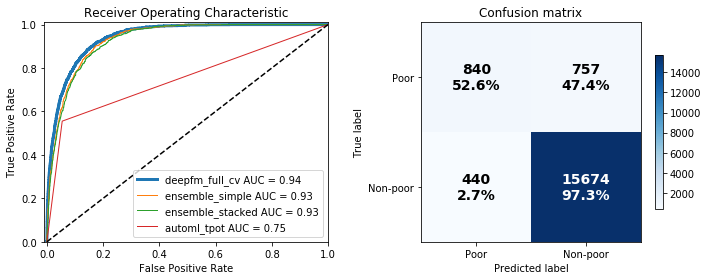

,deepfm_full_cv,ensemble_simple,ensemble_stacked,automl_tpot
accuracy,0.932415,0.845008,0.827208,0.896794
recall,0.525986,0.873189,0.886484,0.555481
precision,0.65625,0.418192,0.390749,0.592262
f1,0.583942,0.565535,0.542411,0.573282
cross_entropy,0.161349,0.34436,0.352263,0.625172
roc_auc,0.943099,0.93394,0.929823,0.750474
cohen_kappa,0.547647,0.464792,0.44074,0.472997


In [6]:
compare_to = ['ensemble_simple', 'ensemble_stacked', 'automl_tpot']

metrics = evaluate_model(y_test, 
                         y_pred, 
                         y_prob,
                         compare_models=compare_to,
                         model_name='full_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

DeepFM does well if not best on many metrics, but its recall is particularly bad. In the next notebook, we will run this model again except we'll use class balancing in an attempt to improve recall.

# Predict On Other Years Of Indonesia Survey Data <a class="anchor" id="predict-on-other-years-of-indonesia-survey-data"></a>

In notebook `19.1-eval-models-new-idn-data` we consider how well the models in this project perform on data from other years. Recall that the main data we're working with is from 2012. Below, we'll load and predict data from 2011, 2013, and 2014.

**NOTE** While every other model is is loaded and makes predictions in notebook `19.1-eval-models-new-idn-data`, the DeepFM model is complex to save to disk, so we perform the predictions for those other years in this notebook.

**NOTE** It is worth emphasizing that for these additional years **all data is test data**, there is no split.

First, load data from other years.

In [7]:
# instantiate data parser to prepare the data
fd = FeatureDictionary(dfTrain=dfTrain, dfTest=dfTest,
                       numeric_cols=config.NUMERIC_COLS,
                       ignore_cols=config.IGNORE_COLS)
data_parser = DataParser(feat_dict=fd)

# 2011
country = 'idn-2011'
dfTest_2011, X_test_2011, ids_test_2011, cat_features_indices_2011 = load_data_for_deepfm('idn-2011', test_only=True)
Xi_test_2011, Xv_test_2011, y_test_2011 = data_parser.parse(df=dfTest_2011, has_label=True)

# 2013
dfTest_2013, X_test_2013, ids_test_2013, cat_features_indices_2013 = load_data_for_deepfm('idn-2013', test_only=True)
Xi_test_2013, Xv_test_2013, y_test_2013 = data_parser.parse(df=dfTest_2013, has_label=True)

# 2014
dfTest_2014, X_test_2014, ids_test_2014, cat_features_indices_2014 = load_data_for_deepfm('idn-2014', test_only=True)
Xi_test_2014, Xv_test_2014, y_test_2014 = data_parser.parse(df=dfTest_2014, has_label=True)

## Predict 2011

We'll predict and save the results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


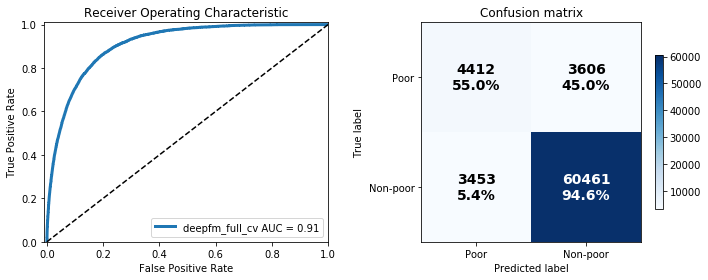

,deepfm_full_cv
accuracy,0.901866
recall,0.550262
precision,0.560966
f1,0.555563
cross_entropy,0.258528
roc_auc,0.909481
cohen_kappa,0.500412


In [8]:
y_test_2011_preds = dfm.predict(Xi_test_2011, Xv_test_2011)

# get test preds
y_test_2011 = dfTest_2011['target'].values.astype(int)
y_pred_2011 = np.round(y_test_2011_preds.ravel())
y_prob_2011 = y_test_2011_preds.ravel()

metrics = evaluate_model(y_test_2011, 
                         y_pred_2011, 
                         y_prob_2011, 
                         model_name='full_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2011',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

## Predict 2013

Predict and save results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


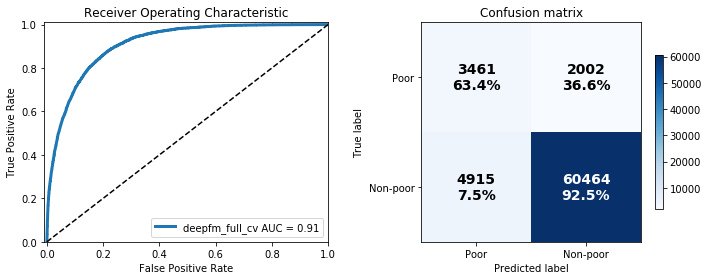

,deepfm_full_cv
accuracy,0.90236
recall,0.633535
precision,0.413204
f1,0.500181
cross_entropy,0.236145
roc_auc,0.910612
cohen_kappa,0.44872


In [9]:
y_test_2013_preds = dfm.predict(Xi_test_2013, Xv_test_2013)

# get test preds
y_test_2013 = dfTest_2013['target'].values.astype(int)
y_pred_2013 = np.round(y_test_2013_preds.ravel())
y_prob_2013 = y_test_2013_preds.ravel()

metrics = evaluate_model(y_test_2013, 
                         y_pred_2013, 
                         y_prob_2013, 
                         model_name='full_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2013',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

## Predict 2014

Predict and save results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


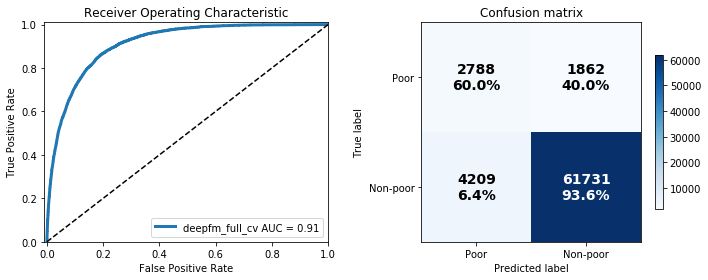

,deepfm_full_cv
accuracy,0.913996
recall,0.59957
precision,0.398456
f1,0.47875
cross_entropy,0.214769
roc_auc,0.911671
cohen_kappa,0.433948


In [10]:
y_test_2014_preds = dfm.predict(Xi_test_2014, Xv_test_2014)

# get test preds
y_test_2014 = dfTest_2014['target'].values.astype(int)
y_pred_2014 = np.round(y_test_2014_preds.ravel())
y_prob_2014 = y_test_2014_preds.ravel()

metrics = evaluate_model(y_test_2014, 
                         y_pred_2014, 
                         y_prob_2014, 
                         model_name='full_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2014',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

# Summary <a class="anchor" id="summary"></a>

The DeepFM model performs well against the other models, but its recall is very poor. In the next notebook we will train the exact same model using undersampled data as a class balancing approach in order to improve recall. 